# Running bandit optimization algorithms with synthetic arms

This section introduces optimization with bandit algorithms, and how our framework works

## testing ε-greedy with Bernoulli arms

ε-greedy is one of the most common bandit algorithms with $\epsilon \in (0,1)$. It explores $\epsilon$ of the times, and exploits $(1-\epsilon)$ of the times.\
We will explore some different ε's for the algorithm, and compare their performances in optimizing with 5 Bernoulli arms.

In [1]:
from arms import BernoulliArm
from algos_regret import EpsilonGreedy
from algos_testfunc import test_algorithm_regret
import utils

# We first build Bernoulli arms
# each Bernoulli arm has an underlying Bernoulli distribution, with a different mean
# The Bernoulli arm with a mean of 0.9 is the optimal arm, which will return a reward 90% of the times on average.
means = [0.1, 0.2, 0.3, 0.4, 0.9]
n_arms = len(means)
arms = list(map(lambda x: BernoulliArm(x), means))

# create directory for output log files
output_dir = utils.make_dir('demofiles/bernoulli/eps_greedy')

# test for ε-greedy algorithms with different pre-set ε's
for eps in [0.1, 0.3, 0.5]:
    algo = EpsilonGreedy(n_arms, eps)
    algo.reset(n_arms)
    results = test_algorithm_regret(algo, arms, num_sims=1000, horizon=250)
    filename = 'epsilon_' + str(eps) + '.csv'
    results.to_csv(output_dir / filename)


## Plotting acquisition results
Once we have the results logs, we can plot the accuracies achieved by different algorithms to compare.\
Seems like ε=0.1 is optimal for this simple test case. Too much exploration is not ideal towards the end.

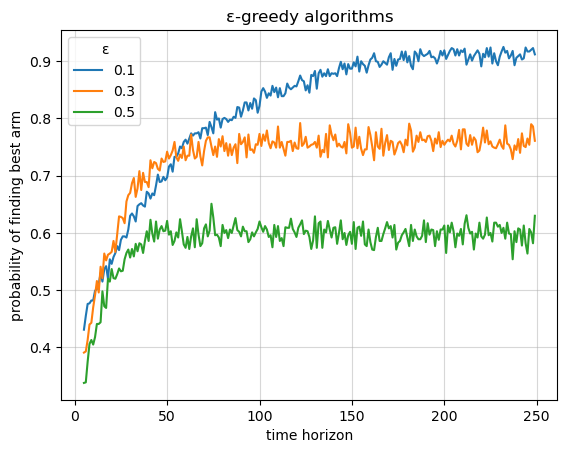

In [3]:
from analyze import plot_probs_choosing_best_arm

eps = [0.1, 0.3, 0.5]
fn_list = [f'demofiles/bernoulli/eps_greedy/epsilon_{e}.csv' for e in eps]

plot_probs_choosing_best_arm(
    fn_list=fn_list,
    legend_list=['0.1', '0.3', '0.5'],
    title='ε-greedy algorithms',
    legend_title='ε',
    best_arm_index=4,  # the index for the most optimal arm. In this case it's the fifth arm (index=4)
    ignore_first_rounds=5
)

There are also plotting functions for average reward and cumulative rewards for analyzing. They usually trend the same as accuracies.

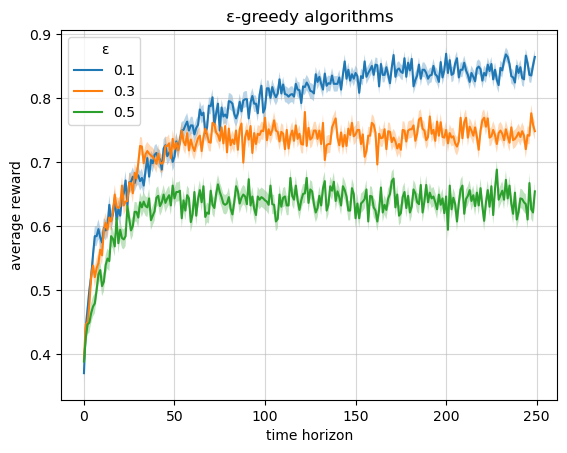

In [4]:
from analyze import plot_average_reward

plot_average_reward(
    fn_list=fn_list,
    legend_list=['0.1', '0.3', '0.5'],
    title='ε-greedy algorithms',
    legend_title='ε',
    show_se=True,
)

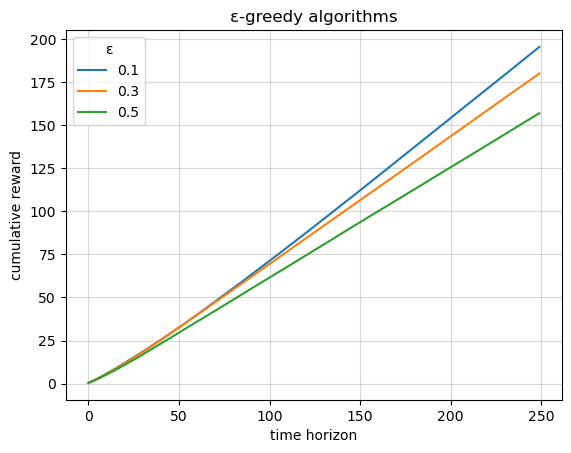

In [5]:
from analyze import plot_cumulative_reward

plot_cumulative_reward(
    fn_list=fn_list,
    legend_list=['0.1', '0.3', '0.5'],
    title='ε-greedy algorithms',
    legend_title='ε',
)

## Simulation with more effective algorithms

We can use more advanced algorithms to achieve a better performance.\
For example, we can use adaptive ε for ε-greedy (annealing ε-greedy), Thompson sampling (beta prior), and Bayes UCB, and compare their performances.

In [1]:
from arms import BernoulliArm
from algos_regret import AnnealingEpsilonGreedy, ThompsonSamplingBeta, BayesUCBBetaPPF
from algos_testfunc import test_algorithm_regret
import utils

# build the same Bernoulli arms
means = [0.1, 0.2, 0.3, 0.4, 0.9]
n_arms = len(means)
arms = list(map(lambda x: BernoulliArm(x), means))

# create directory for output log files
output_dir = utils.make_dir('demofiles/bernoulli/advanced algo')

# test three more advanced algos
# NOTE: BayesUCBBetaPPF is quite slow, due to its need to calculate percent point functin of beta distribution at each step
for algo in [AnnealingEpsilonGreedy(n_arms), ThompsonSamplingBeta(n_arms), BayesUCBBetaPPF(n_arms)]:
    algo.reset(n_arms)
    results = test_algorithm_regret(algo, arms, num_sims=1000, horizon=250)
    filename = f'{algo.__str__()}.csv'
    results.to_csv(output_dir / filename)

## plot acquisition results and compare with previous ε-greedy results

Compared to the ε-greedy algorithms we previously tested, more advanced algorithms converged significantly faster

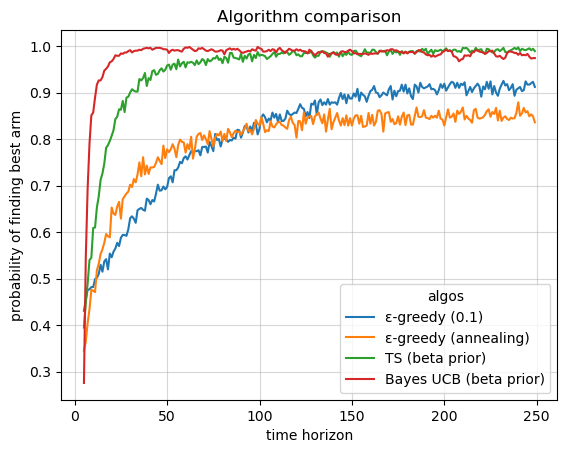

In [7]:
from analyze import plot_probs_choosing_best_arm

fn_list = ['eps_greedy/epsilon_0.1.csv',
           'advanced algo/eps_greedy_annealing.csv',
           'advanced algo/ts_beta.csv',
           'advanced algo/bayes_ucb_beta_ppf.csv'
           ]
fn_list = [f'demofiles/bernoulli/{f}' for f in fn_list]

plot_probs_choosing_best_arm(
    fn_list=fn_list,
    legend_list=['ε-greedy (0.1)',
                 'ε-greedy (annealing)',
                 'TS (beta prior)',
                 'Bayes UCB (beta prior)'],
    title='Algorithm comparison',
    legend_title='algos',
    best_arm_index=4,  # the index for the most optimal arm. In this case it's the fifth arm (index=4)
    ignore_first_rounds=5
)

## Further discussion
There are more algorithms implemented than discussed here. They can all be found in [algos_regret.py](algos_regret.py)

We have conducted extensive benchmarking on many Bernoulli and Gaussian test scenarios to compare algorithm performance in different scenarios.\
Details about these testings can be found in the Supplementary Information of the paper.\
All testing logs can be found at repository [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.8170875.svg)](https://doi.org/10.5281/zenodo.8170875)

# Running bandit optimization for chemistry reactions

In this section, we will show how to run bandit optimization for chemistry reactions.

The biggest difference, compared to synthetic data, is that the reaction scope needs to be considered. We implemented a Scope object that handle all operations for the reaction scope, such as initialize the scope with substrates and conditions, update results for explored reactions, query existing results... However, for most usage cases, we have written wrapper functions that can handle most operations automatically, and do not have to interact with Scope a lot.

In the paper (optimization study 2), we conducted an optimization run for the amide coupling dataset. We'll use that as an example here to show the steps needed to run bandit optimization in real time.

## Set up reaction scope

The first thing to do is to decide on your reaction scope, which involves choosing the substrates and reaction conditions. Since we already chose the scope for the amide coupling study, we are going to cheat a little bit here and load them directly from our collected data. When using this in real time, you should have one list for each reaciton component. They can be lists of smiles, or labels, or names, anything that can differentiate them.

In [2]:
import pandas as pd
import utils

# load data
df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/ami.csv')
df['yield'] = df['yield'].apply(utils.scaler)  # scales 0-100% yield to 0-1
smiles_to_id = dict(zip(df['nucleophile_smiles'].unique(), df['nucleophile_id'].unique()))  # used for next section, it converts smiles to id for substrates
df = df[['activator_name', 'solvent_name', 'base_name', 'nucleophile_id', 'yield']]

bases = df['base_name'].unique()
activators = df['activator_name'].unique()
solvents = df['solvent_name'].unique()
nucleophiles = df['nucleophile_id'].unique()

activators

array(['PFTU', 'TCFH', 'HATU', 'PyBOP', 'BOP-Cl', 'TFFH', 'DPPCl', 'HOTU'],
      dtype=object)

## Create necessary encodings for some reaction components
Our stochastic bandit optimization model actually does not need any encodings for molecules, and optimizes through sampling different and independent choices of conditions

Sometimes, chemically meaningful encodings are desired. For example, when we propose multiple experiments in a batch, we can take the approach of using a supervised learning model to supply predicted results to the algorithm so the next experiment can be proposed (see SI for details). In this case, encodings for molecules might be helpful.

Since we already created encodings, we are going to load them directly here. More specifically, we'll only load up the  When using this in practice, use any molecular fingerprints/descriptors/features you like, just supply them as a dictionary in a similar format. If no encodings are supplied for a reaction component, our model one hot encodes it automatically (which can be very effective, especially with limited number of options

In [6]:
# grab encodings for substrates
encodings = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/amidation/mols/morganFP/nucleophile.csv')
encodings.set_index('nucleophile_smiles', inplace=True)
ordered_ids = [smiles_to_id[s] for s in encodings.index]  # our original encodings are organized with smiles, we use the dictionary we made to convert them to id
encodings = dict(zip(ordered_ids, encodings.to_numpy().tolist()))  # {id: [ECFP1, ECFP2, ...]}
encodings = {'nucleophile_id': encodings}  # one more level to specify that it's substrates

# encodings is a two-level dictionary: first key is reaction component type, second key is actual reaction components
# the values, which is the features, are supplied as a list for each molecule
print(encodings.keys())
print(encodings['nucleophile_id'].keys())
print(encodings['nucleophile_id']['n1'])

dict_keys(['nucleophile_id'])
dict_keys(['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

## propose initial experiments

Now we are ready to propose the first experiments with a wrapper function `propose_initial_experiments_interpolation()`. Interpolation was the one we used for batch proposals, and its batch proposal was specifically done with one algorithm and a prediction model for interpolation.

We also have a more basic version of `propose_initial_experiments()`, which also supports batch operation via other methods. Details can be found in the SI, and all methods described here can be found in [chem_arms.py](./chem_arms.py)

In [7]:
from chem_arms import propose_initial_experiments_interpolation
from algos_regret import UCB1Tuned

# set up some dictionaries for the function
wkdir = 'demofiles/amide run/'  # where all the files are saved
scope_dict = {'base_name': bases,
              'activator_name': activators,
              'solvent_name': solvents,
              'nucleophile_id': nucleophiles}  # a dictionary for the scope, with all of our chosen molecules
arms_dict = {'activator_name': activators}  # arm_dict is a dictionary of arms, or conditions that we want to optimize. We are only optimizing for activators here.
algo = UCB1Tuned(len(activators))  # choose a bandit algorithm

# propose initial experiments now, we want 5 initial experiments
propose_initial_experiments_interpolation(scope_dict, arms_dict, algo, dir=wkdir, num_exp=5)

If we go to the directory, you will find a folder `cache`, and a file `proposed_experiments.csv`. The `cache` folder has all the things algorithm needs to keep running, but we don't need to use it. `proposed_experiments.csv` has our proposed experiments.

In [8]:
import pandas as pd
fd = pd.read_csv(f'{wkdir}/proposed_experiments.csv')
fd

,Unnamed: 0,activator_name,base_name,nucleophile_id,solvent_name,yield,prediction
0,115,PFTU,Diisopropylethylamine,n9,MeCN,NaN,1.0
1,231,TCFH,Diisopropylethylamine,n8,THF,NaN,1.0
2,282,HATU,"2,6-Lutidine",n5,THF,NaN,1.0
3,362,PyBOP,1-Methylimidazole,n1,DMF,NaN,1.0
4,556,BOP-Cl,N-methylmorpholine,n6,MeCN,NaN,1.0


## Fill in experimental results, and propose the next round of experiments

# Simulating bandit optimization with chemistry reaction dataset
This section describes how to simulate optimization with chemistry reaction dataset.\
The overall structure is very similar to

## set up the reaction scope